<a href="https://colab.research.google.com/github/JungWoo-Chae/GANs-in-action/blob/master/WGAN_GP_FMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **WGAN GP with FMNIST**


## **Imports**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.autograd import Variable
from torch import autograd

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## **Model**

In [3]:
class Generator(torch.nn.Module):
    def __init__(self, channels, nf):
        super().__init__()
        self.main_module = nn.Sequential(
            nn.ConvTranspose2d(in_channels=100, out_channels=nf*4, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(num_features=nf*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=nf*4, out_channels=nf*2, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(num_features=nf*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=nf*2, out_channels=nf, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=nf),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=nf , out_channels=channels, kernel_size=4, stride=2, padding=1))

        self.output = nn.Tanh()

    def forward(self, x):
        x = self.main_module(x)
        return self.output(x)

In [4]:
class Discriminator(torch.nn.Module):
    def __init__(self, channels, nf):
        super().__init__()

        self.main_module = nn.Sequential(
            nn.Conv2d(in_channels=channels, out_channels=nf, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(nf, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=nf, out_channels=nf*2, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(nf*2, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=nf*2, out_channels=nf*4, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(nf*4, affine=True),
            nn.LeakyReLU(0.2, inplace=True))

        self.output = nn.Sequential(
            nn.Conv2d(in_channels=nf*4, out_channels=1, kernel_size=3, stride=1, padding=0)
            )
        
    def forward(self, x):
        x = self.main_module(x)
        return self.output(x)

In [5]:
z_dim = 100
channels = 1
nf = 64

In [6]:
D = Discriminator(channels, nf)
D = D.to(device)
G = Generator(channels, nf)
G = G.to(device)

In [7]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5), (0.5)),
    ])

In [8]:
dataset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Training

In [9]:
losses = []
checkpoints = []

In [10]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    alpha = torch.randn(real_samples.size(0), 1, 1, 1, device=device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.ones(d_interpolates.size()).to(device).requires_grad_(False)

    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [11]:
losses = []
checkpoints = []

def train(epochs, batch_size, sample_interval):
    
    D.train()
    G.train()

    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           shuffle=True, num_workers=4, pin_memory=True)
    
    d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
    g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

    for epoch in range(epochs):
        iteration = 0
        for imgs, _ in train_loader:    
            imgs = imgs.to(device)

            if len(imgs) != batch_size:
                break
            
            for p in D.parameters():
                    p.requires_grad = True
            
            D.zero_grad()
            
            
            z = torch.randn(batch_size, z_dim,1,1, device=device)
            gen_imgs = G(z)
            gradient_penalty = compute_gradient_penalty(D, imgs.data, gen_imgs.data)
            d_loss = -1 * torch.mean(D(imgs)) + torch.mean(D(gen_imgs)) + 10 * gradient_penalty

            d_loss.backward()
            d_optimizer.step()


            if iteration%5==0:
                for p in D.parameters():
                    p.requires_grad = False

                G.zero_grad()
                
                z = torch.randn(batch_size, z_dim,1,1, device=device)
                gen_imgs = G(z)
                g_loss = - torch.mean(D(gen_imgs))
                 
                g_loss.backward()
                g_optimizer.step()

            iteration +=1

        print("%d/%d [D loss: %f] [G loss: %f]" % (epoch + 1, epochs, d_loss.item(), g_loss.item()))
        if (epoch+1) % sample_interval == 0:
            losses.append((d_loss.cpu().detach().numpy(), g_loss.cpu().detach().numpy()))
            checkpoints.append(epoch + 1)
            
            sample_images(G)
            

In [12]:
def sample_images(generator, t=3, image_grid_rows=2, image_grid_columns=5):

    z = torch.randn(image_grid_rows * image_grid_columns, z_dim, 1, 1, device=device)

    labels = np.arange(0, 10)
    labels = torch.tensor(labels).to(device)

    gen_imgs = generator(z).cpu().detach()

    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(10, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i,j].imshow(gen_imgs[cnt].view(28,28), cmap='gray')
            axs[i, j].axis('off')
            cnt += 1









1/40 [D loss: -15.450688] [G loss: 12.833309]
2/40 [D loss: -9.514452] [G loss: 8.186346]
3/40 [D loss: -7.507905] [G loss: 6.028008]
4/40 [D loss: -7.485368] [G loss: 4.935551]
5/40 [D loss: -7.290216] [G loss: 5.399448]
6/40 [D loss: -6.736351] [G loss: 5.407101]
7/40 [D loss: -6.506123] [G loss: 6.842250]
8/40 [D loss: -6.258909] [G loss: 7.004739]
9/40 [D loss: -5.512295] [G loss: 7.069251]
10/40 [D loss: -5.499277] [G loss: 7.611135]
11/40 [D loss: -5.385000] [G loss: 7.872809]
12/40 [D loss: -5.230204] [G loss: 7.581615]
13/40 [D loss: -5.105700] [G loss: 8.835028]
14/40 [D loss: -5.082229] [G loss: 8.800751]
15/40 [D loss: -4.927014] [G loss: 9.689586]
16/40 [D loss: -4.689733] [G loss: 8.609892]
17/40 [D loss: -4.624013] [G loss: 9.422539]
18/40 [D loss: -4.451086] [G loss: 9.848869]
19/40 [D loss: -4.561351] [G loss: 9.752085]
20/40 [D loss: -4.455629] [G loss: 10.276344]
21/40 [D loss: -4.325778] [G loss: 10.792070]
22/40 [D loss: -4.081438] [G loss: 11.113596]
23/40 

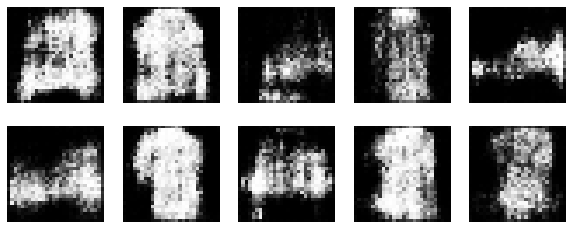

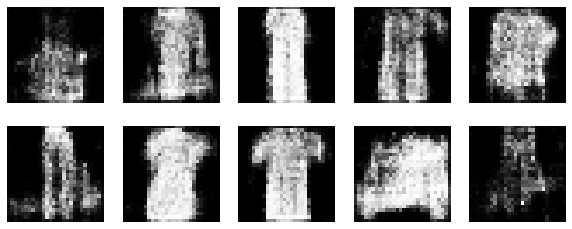

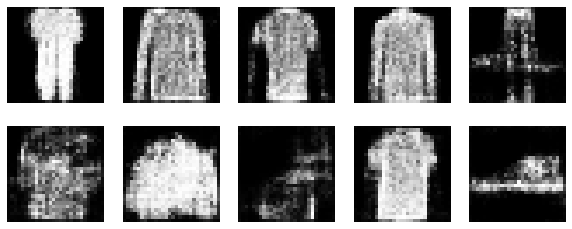

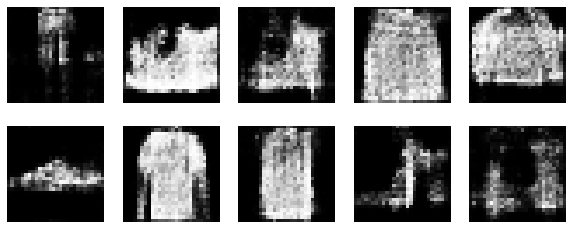

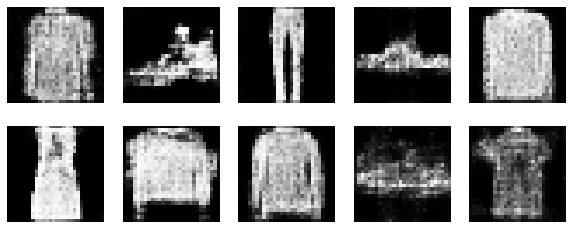

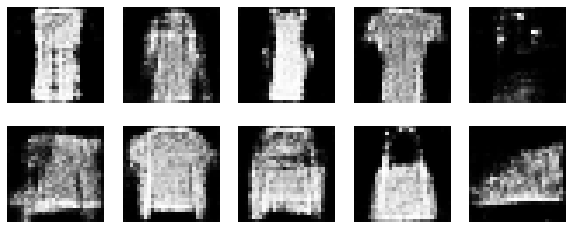

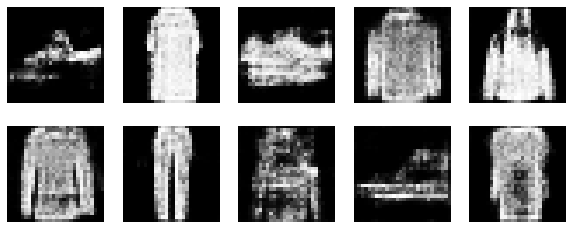

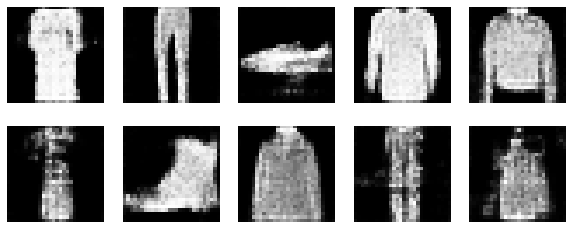

In [13]:
epochs = 30
batch_size = 1024
sample_interval = 5

train(epochs, batch_size, sample_interval)

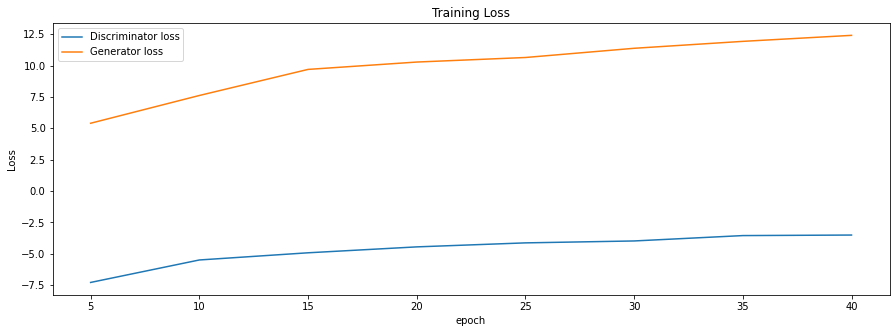

In [14]:
losses_ = np.array(losses)

plt.figure(figsize=(15, 5))
plt.plot(checkpoints, losses_.T[0], label="Discriminator loss")
plt.plot(checkpoints, losses_.T[1], label="Generator loss")

plt.title("Training Loss")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()